In [1]:
from google.colab import drive
drive.mount('/content/drive')

dataset = "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip"

Mounted at /content/drive


In [2]:
!unzip -o "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/deepfake_database/validation/df/162_156.jpg  
  inflating: /content/deepfake_database/validation/df/162_158.jpg  
  inflating: /content/deepfake_database/validation/df/162_16.jpg  
  inflating: /content/deepfake_database/validation/df/162_160.jpg  
  inflating: /content/deepfake_database/validation/df/162_164.jpg  
  inflating: /content/deepfake_database/validation/df/162_168.jpg  
  inflating: /content/deepfake_database/validation/df/162_174.jpg  
  inflating: /content/deepfake_database/validation/df/162_176.jpg  
  inflating: /content/deepfake_database/validation/df/162_18.jpg  
  inflating: /content/deepfake_database/validation/df/162_184.jpg  
  inflating: /content/deepfake_database/validation/df/162_20.jpg  
  inflating: /content/deepfake_database/validation/df/162_22.jpg  
  inflating: /content/deepfake_database/validation/df/162_26.jpg  
  inflating: /content/deepfake_database/validation/df/162_28.jpg  
  i

In [3]:
import tensorflow as tf
import dlib
import cv2
import os
import numpy as np

# Preprocessing

In [4]:
extracted_frames_folder = 'deepfake_database'
fake_frames = os.path.join(extracted_frames_folder, 'validation/df/')
real_frames = os.path.join(extracted_frames_folder, 'validation/real/')
image_format = '.jpg'
SIZE = 200

In [5]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image

def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for f in listOfFile:
        if f.endswith(image_format):
            allFiles.append(f)
    return allFiles

'''
def preprocess(image_path):
    image = load_img(image_path)
    image = img_to_array(image)
    #image = image.flatten() / 255.0
    return image
'''

def preprocess2(image_path):
    image = cv2.imread(image_path)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((SIZE, SIZE))
    return image

def preprocess3(image_path):
    image = cv2.imread(image_path)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((SIZE, SIZE))
    image = np.array(image)
    image = image / 255.0
    return image


## Store in arrays

In [6]:
import numpy as np
from keras.utils import normalize

real_data = getListOfFiles(real_frames)
print("No. of Real Images: " + str(len(real_data)))
fake_data = getListOfFiles(fake_frames)
print("No. of Fake Images: " + str(len(fake_data)))

images = []
labels = []

for img in real_data:
    image = preprocess2(real_frames + img)
    images.append(np.array(image))
    labels.append(1)

for img in fake_data:
    image = preprocess2(fake_frames + img)
    images.append(np.array(image))
    labels.append(0)

labels = np.array(labels)
images = np.array(images)
images = normalize(images, axis=1, order=2)
labels


No. of Real Images: 4259
No. of Fake Images: 2845


array([1, 1, 1, ..., 0, 0, 0])

In [7]:
type(images[0][0][0][0])

numpy.float64

# Prediction

In [8]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Thesis/deepfake-detection-master/Meso4.h5')

In [9]:
y_pred = (model.predict(images) > 0.5).astype("int32")

In [10]:
import matplotlib.pyplot as plt
predictions = []
count = 0
for pred in y_pred:
    predictions.append(pred)
    

## Model Evaluate

In [11]:
#labels = np.array(labels)
#images = np.array(images)
#images_val = normalize(images, axis=1)
_, acc = model.evaluate(images, labels)
print("Accuracy = ", (acc * 100.0), "%")


222/222 [==============================] - 2s 7ms/step - loss: 0.0827 - accuracy: 0.8972
Accuracy =  89.72409963607788 %


## Classification Report

In [12]:
from sklearn.metrics import classification_report
target_names = ['Fake', 'Real']
print(classification_report(labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

        Fake       0.81      0.98      0.88      2845
        Real       0.98      0.84      0.91      4259

    accuracy                           0.90      7104
   macro avg       0.89      0.91      0.90      7104
weighted avg       0.91      0.90      0.90      7104



## Confusion Matrix

True positive =  2780
False positive =  65
False negative =  665
True negative =  3594




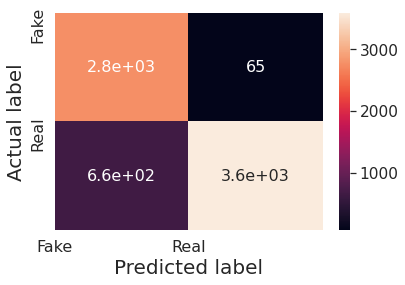

In [13]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(labels, predictions)

In [14]:
'''
input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('test_videos/jzmzdispyo.mp4')
frameRate = cap.get(5)
predictions = []
while cap.isOpened():
    frameId = cap.get(1)
    ret, frame = cap.read()
    if ret != True:
        break
    if frameId % ((int(frameRate)+1)*1) == 0:
        face_rects, scores, idx = detector.run(frame, 0)
        for i, d in enumerate(face_rects):
            x1 = d.left()
            y1 = d.top()
            x2 = d.right()
            y2 = d.bottom()
            crop_img = frame[y1:y2, x1:x2]
            data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
            data = data.reshape(-1, 128, 128, 3)
            print(model.predict_classes(data)[0])
            predictions.append(model.predict_classes(data)[0])
print(predictions)
'''

"\ninput_shape = (128, 128, 3)\npr_data = []\ndetector = dlib.get_frontal_face_detector()\ncap = cv2.VideoCapture('test_videos/jzmzdispyo.mp4')\nframeRate = cap.get(5)\npredictions = []\nwhile cap.isOpened():\n    frameId = cap.get(1)\n    ret, frame = cap.read()\n    if ret != True:\n        break\n    if frameId % ((int(frameRate)+1)*1) == 0:\n        face_rects, scores, idx = detector.run(frame, 0)\n        for i, d in enumerate(face_rects):\n            x1 = d.left()\n            y1 = d.top()\n            x2 = d.right()\n            y2 = d.bottom()\n            crop_img = frame[y1:y2, x1:x2]\n            data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0\n            data = data.reshape(-1, 128, 128, 3)\n            print(model.predict_classes(data)[0])\n            predictions.append(model.predict_classes(data)[0])\nprint(predictions)\n"

In [15]:
'''
from collections import Counter
b = Counter(predictions)
print(b.most_common(1)[0][0])
'''

'\nfrom collections import Counter\nb = Counter(predictions)\nprint(b.most_common(1)[0][0])\n'